# Reproducing Fig. S4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyscripts.config import path2
from pyscripts.datasets import Metadata
from pyscripts.visualization import ColorUniversalDesign as CUD
metadata = Metadata()

In [2]:
habitablity_scores = pd.read_pickle(path2.data/'prokatlas'/'summary.pkl.bz2')
idp_summary = pd.read_pickle(path2.data/'iupred2a'/'summary.pkl.bz2')
idp_summary = idp_summary.swaplevel(0,1,axis=1).swaplevel(1,2,axis=1).sort_index(axis=1)

In [3]:
gtdbrep2refseq = metadata.acc.set_index('gtdbrep')['refseq']
refseq2gtdbrep = metadata.acc.set_index('refseq')['gtdbrep']
acc_ordered = pd.DataFrame([
    (refseq_acc, gtdb_acc)
    for gtdb_acc in metadata.bac120_tree.iter_leaf_names() 
    if (refseq_acc := gtdbrep2refseq.get(gtdb_acc)) is not None
], columns=['refseq', 'gtdbrep'])
gtdb_taxonomy = metadata.taxrank_inuse.loc[acc_ordered['gtdbrep']]

phylum_counts = gtdb_taxonomy['phylum'].value_counts()[gtdb_taxonomy['phylum'].unique()]
top_idx = phylum_counts[phylum_counts >= 40].sort_values(ascending=False).index
phylum_masked = gtdb_taxonomy['phylum'].where(gtdb_taxonomy['phylum'].isin(top_idx), '(others)')
phylum_color = (phylum_counts.rank(method='first', ascending=False).astype(int)-1).apply(CUD.OkabeIto_cmap)

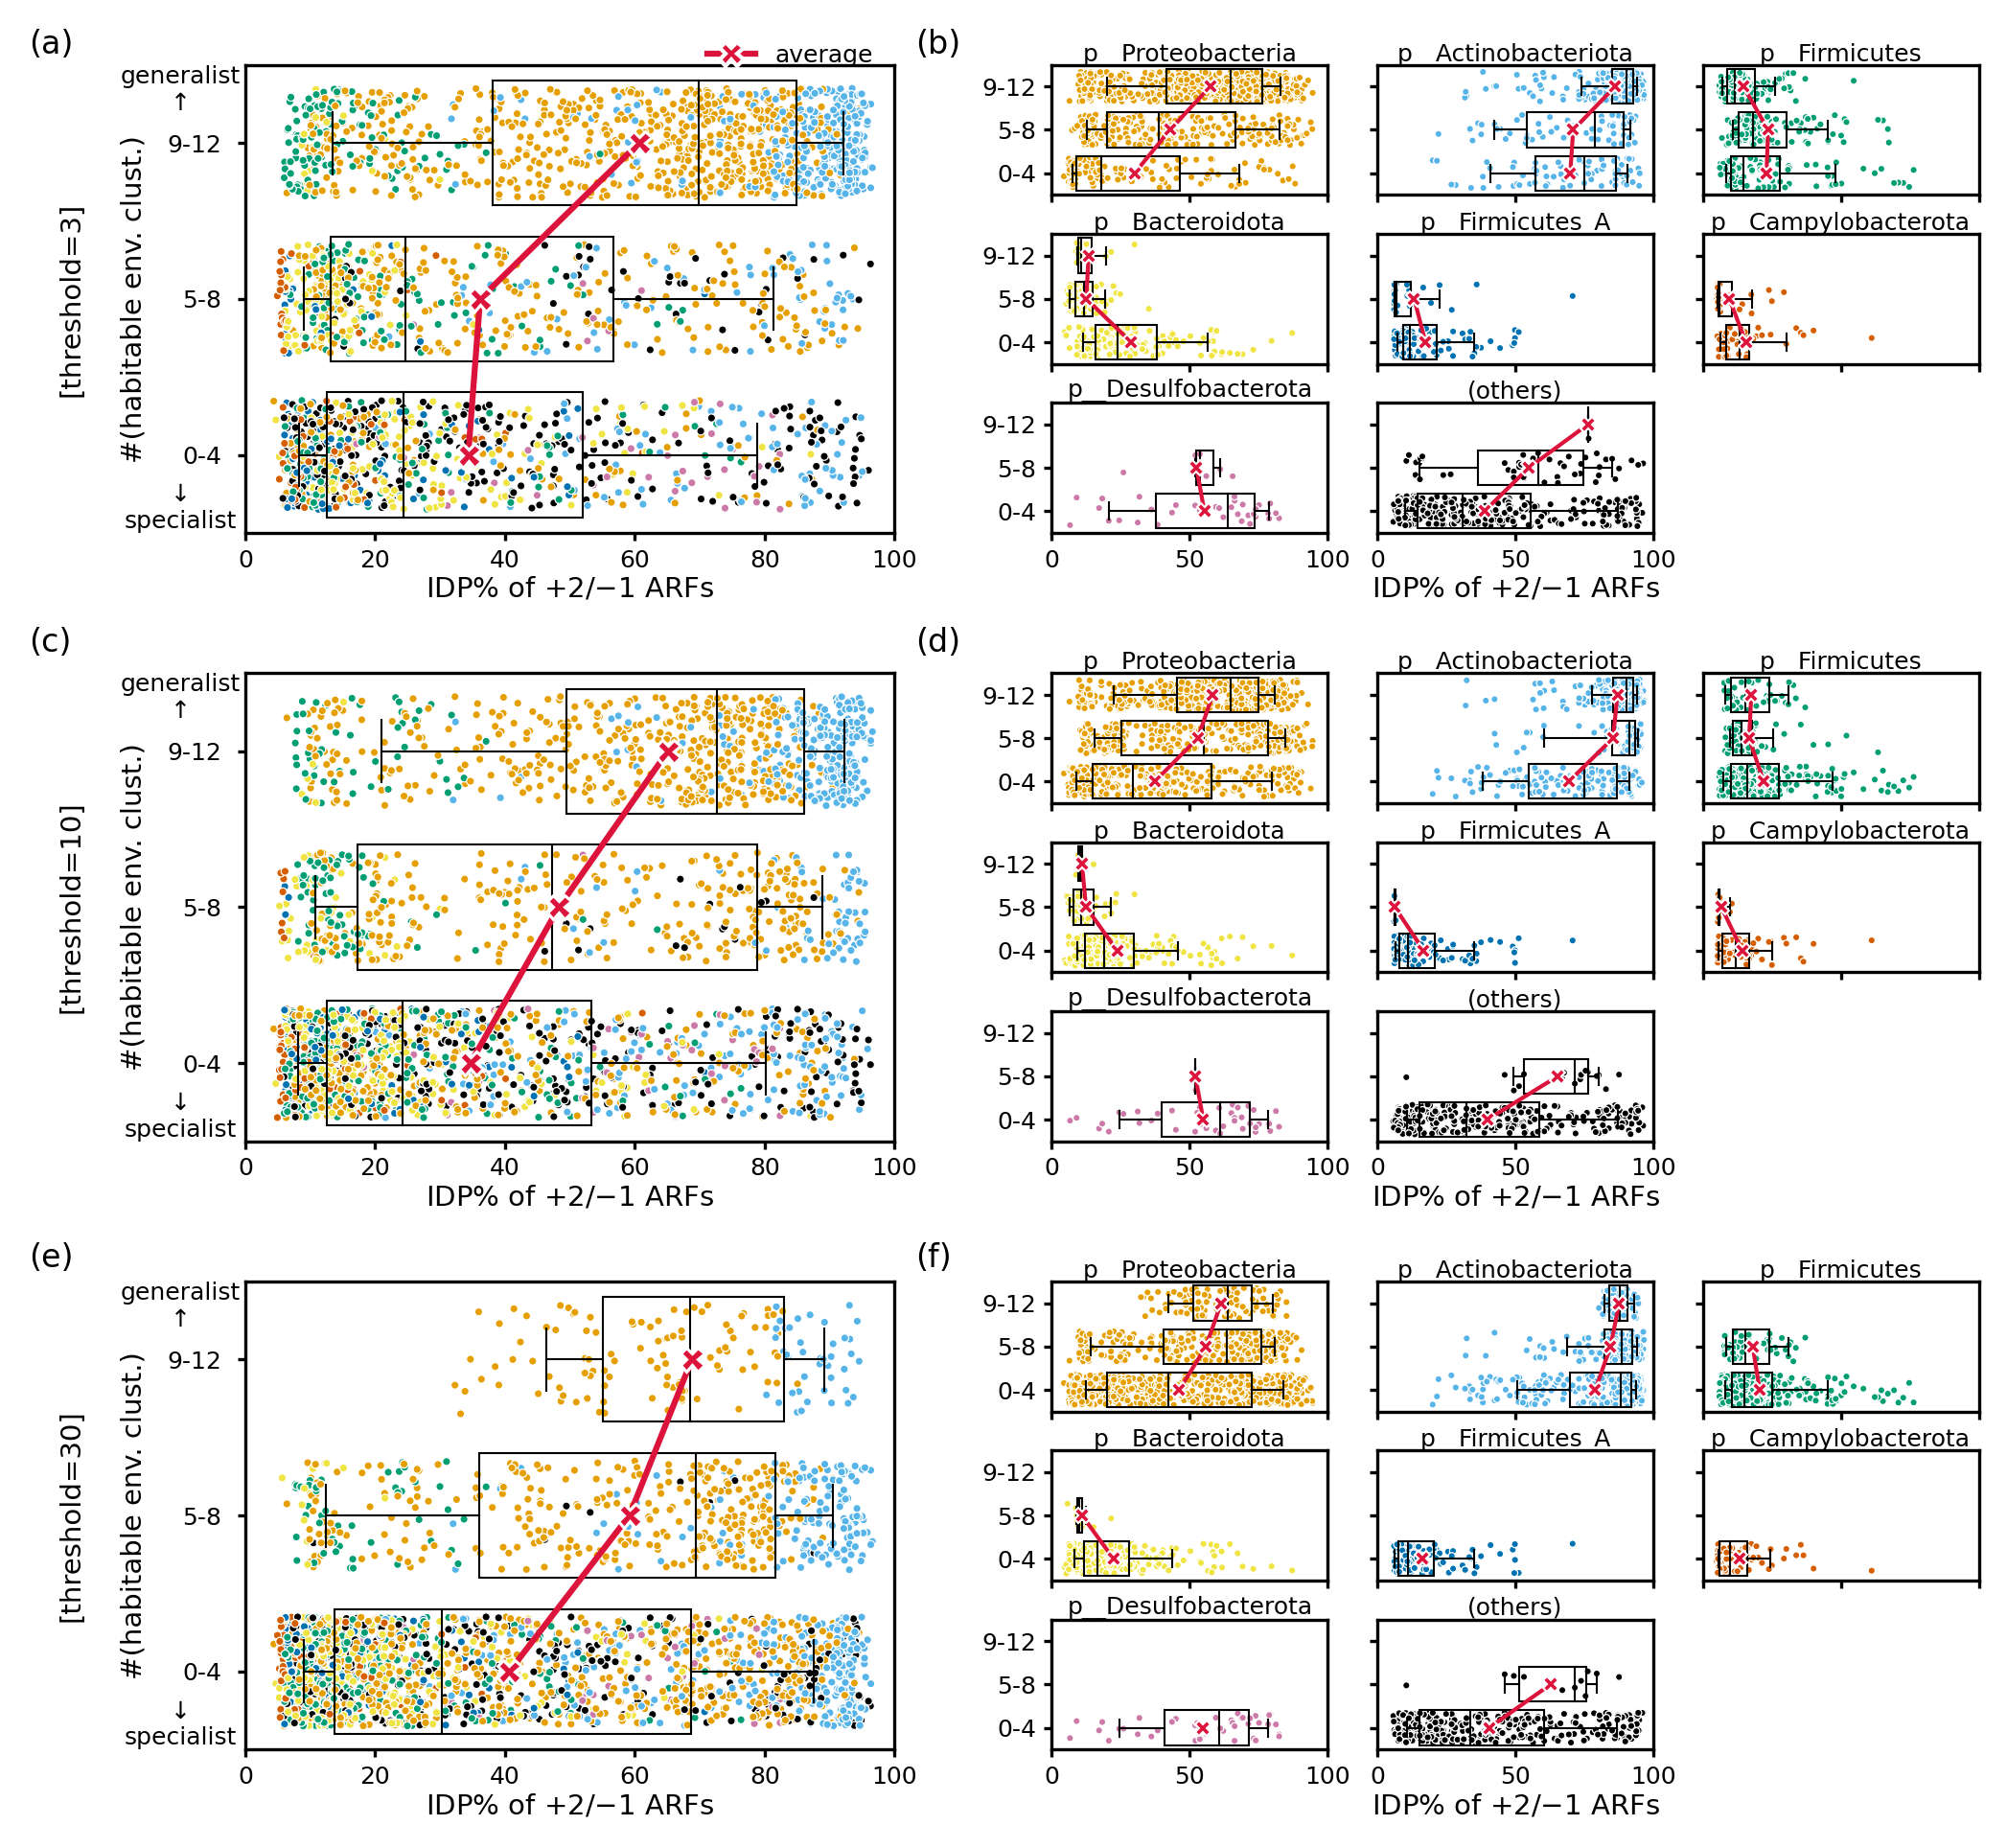

In [8]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

mm = 1 / 25.4
with plt.rc_context({'font.size': 7, 'xtick.labelsize': 6, 'ytick.labelsize': 6}):
    fig = plt.figure(figsize=(174*mm, 160*mm), dpi=300)
    # prepare axes
    axes_all, axes_phy_list = [], []
    for gs_main in GridSpec(3, 1, hspace=0.3):
        gs_sub = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_main, width_ratios=[1.4, 2], wspace=0.2)
        axes_all.append(fig.add_subplot(gs_sub[0]))
        axes_phy_list.append([
            fig.add_subplot(gs)
            for gs in GridSpecFromSubplotSpec(3, 3, subplot_spec=gs_sub[1], hspace=0.3, wspace=0.18)
        ])
        fig.delaxes(axes_phy_list[-1][-1])
        
    # plots
    for th, ax_all, axes_phy in zip((3, 10, 30), axes_all, axes_phy_list):
        pltdat = pd.concat([
            (habitablity_scores > th).sum().map({
                0:  '0-4',  1:  '0-4',  2:  '0-4',  3:  '0-4', 4: '0-4',
                5:  '5-8',  6:  '5-8',  7:  '5-8',  8:  '5-8', 
                9: '9-12', 10: '9-12', 11: '9-12', 12: '9-12'
            }),
            (idp_summary[30, 0.5] / idp_summary[30, 0]).loc[[4,16]].mean().fillna(0) * 100,
            refseq2gtdbrep.map(phylum_masked)
        ], axis=1, keys=['#envs', 'IDP%', 'phylum'])

        conf=dict(zorder=1, c='k')
        
        sns.boxplot(
            x='IDP%', y='#envs', order=['0-4', '5-8', '9-12'], data=pltdat, ax=ax_all,
            color='w', orient='h', linewidth=0.5, 
            boxprops=dict(zorder=1, ec='k', fc='none'), capprops=conf, medianprops=conf, 
            whiskerprops=conf, whis=[10, 90], showfliers=False, 
        )
        sns.stripplot(
            x='IDP%', y='#envs', order=['0-4', '5-8', '9-12'], data=pltdat, ax=ax_all,
            hue='phylum', hue_order=[*top_idx, '(others)'], zorder=1,
            jitter=0.35, s=2, orient='h', ec='w', linewidth=0.3, palette=CUD.OkabeIto_cpal, 
        )
        sns.lineplot(
            x='IDP%', y='#envs', data=pltdat.groupby('#envs').mean().reindex(['0-4', '5-8', '9-12']).reset_index().assign(sty='mean'),
            color='crimson', sort=False, ax=ax_all, zorder=2, lw=1.5, style='sty', markers='X'
        )
        ax_all.legend().remove()
        ax_all.text(-10,  2.5, 'generalist\n↑', fontsize=6, va='top', ha='center')
        ax_all.text(-10, -0.5, '↓\nspecialist', fontsize=6, va='bottom', ha='center')
        ax_all.set_xlabel('IDP% of $+2$/$-1$ ARFs', labelpad=1)
        ax_all.set_ylabel(f'[threshold={th}]\n\n#(habitable env. clust.)', labelpad=5)
        ax_all.set_xlim(0, 100)
        ax_all.set_ylim(-0.5, 2.5)
        ax_all.xaxis.set_tick_params(size=2, pad=2)
        ax_all.yaxis.set_tick_params(size=2, pad=4)
        
        for phy, ax in zip([*top_idx, '(others)'], axes_phy):
            pltdat_sub = pltdat[pltdat['phylum'] == phy]
            sns.boxplot(
                x='IDP%', y='#envs', order=['0-4', '5-8', '9-12'], data=pltdat_sub, ax=ax,
                color='w', orient='h', linewidth=0.5, 
                boxprops=dict(zorder=1, ec='k', fc='none'), capprops=conf, medianprops=conf, 
                whiskerprops=conf, whis=[10, 90], showfliers=False, 
            )
            sns.stripplot(
                x='IDP%', y='#envs', order=['0-4', '5-8', '9-12'], data=pltdat_sub, ax=ax,
                hue='phylum', hue_order=[*top_idx, '(others)'], zorder=1,
                jitter=0.35, s=1.75, orient='h', ec='w', linewidth=0.3, palette=CUD.OkabeIto_cpal, 
            )
            sns.lineplot(
                x='IDP%', y='#envs', data=pltdat_sub.groupby('#envs').mean().reindex(['0-4', '5-8', '9-12']).reset_index().assign(sty='mean'),
                color='crimson', sort=False, ax=ax, zorder=2, lw=1, style='sty', markers='X', ms=4, mew=0.5
            )
            ax.legend().remove()
            ax.set_xlim(0, 100)
            ax.set_ylim(-0.5, 2.5)
            ax.set_xlabel(None)
            ax.set_ylabel(None)
            ax.xaxis.set_tick_params(size=2, pad=2)
            ax.yaxis.set_tick_params(size=2, pad=2)
            ax.set_title(phy, fontsize=6, pad=1)
        
        axes_phy[7].set_xlabel('IDP% of $+2$/$-1$ ARFs', labelpad=1)
            
        for ax in axes_phy:
            ax.xaxis.set_tick_params(labelbottom=False) 
            ax.yaxis.set_tick_params(labelleft=False) 
        for ax in axes_phy[6:9]:
            ax.xaxis.set_tick_params(labelbottom=True) 
        for ax in axes_phy[0:9:3]:
            ax.yaxis.set_tick_params(labelleft=True) 
            
    axes_all[0].legend([plt.Line2D([0], [0], color='crimson', marker='X', mec='w')], ['average'], frameon=False, bbox_to_anchor=(1, 0.95), loc='lower right', fontsize=6)
    fig.text(0, 1, '(a)', va='top', ha='left', fontsize=8)
    fig.text(0.45, 1, '(b)', va='top', ha='left', fontsize=8)
    fig.text(0, 0.67, '(c)', va='top', ha='left', fontsize=8)
    fig.text(0.45, 0.67, '(d)', va='top', ha='left', fontsize=8)
    fig.text(0, 0.33, '(e)', va='top', ha='left', fontsize=8)
    fig.text(0.45, 0.33, '(f)', va='top', ha='left', fontsize=8)
    fig.subplots_adjust(left=0.11, right=0.99, bottom=0.05, top=0.98)
    fig.savefig('./Figs/FigS4.pdf')
    fig.patch.set_facecolor('w')
    fig.savefig('./Figs/FigS4.tif')